Project Name: **Deep Learning-Based Brain Tumor Detection in MRI Scans**

Prepared On: *02 Feb 2025*

# About the Dataset

The dataset you’re working with is a collection of MRI scans categorized into two classes:

`No Tumor: Contains 80 grayscale images labeled as N1, N2, ..., N80.`

`Tumor: Contains 150 grayscale images labeled as Y1, Y2, ..., Y150.`




# Import Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# 2. Load and Preprocess the data

In [ ]:
def load_images(folder, label):
    images = []
    labels = []
    # Loop Through All Images in the Folder
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        img = np.stack((img,)*3, axis=-1)  # Convert to 3 channels
        img = img / 255.0  # Normalize to [0, 1]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load "no" and "yes" images
no_images, no_labels = load_images('/content/drive/MyDrive/brain_tumor_dataset/no', 0)  # 0 for "no tumor"
yes_images, yes_labels = load_images('/content/drive/MyDrive/brain_tumor_dataset/yes', 1)  # 1 for "tumor"

# Combine data
X = np.concatenate((no_images, yes_images), axis=0)
y = np.concatenate((no_labels, yes_labels), axis=0)

# Shuffle data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# 3. Split data into train,Validation and Test

In [ ]:
# Split into training (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")
print(f"Test data: {X_test.shape}, {y_test.shape}")

Training data: (177, 224, 224, 3), (177,)
Validation data: (38, 224, 224, 3), (38,)
Test data: (38, 224, 224, 3), (38,)


# 4. Data Argumentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotate images randomly
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shearing transformation
    zoom_range=0.2,  # Zooming in/out
    horizontal_flip=True,  # Flip images
    validation_split=0.2  # Split for validation
)

val_datagen = ImageDataGenerator()  # No augmentation for validation/test data

# Create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = val_datagen.flow(X_test, y_test, batch_size=32)

# Step 5: Load the VGG16 model

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# 6. Train the Model

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 188s 32s/step - accuracy: 0.4826 - loss: 0.9138 - val_accuracy: 0.3158 - val_loss: 0.7894
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 139s 24s/step - accuracy: 0.5814 - loss: 0.7431 - val_accuracy: 0.6842 - val_loss: 0.5949
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 144s 26s/step - accuracy: 0.6350 - loss: 0.6524 - val_accuracy: 0.3684 - val_loss: 0.7606
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 142s 24s/step - accuracy: 0.6117 - loss: 0.6726 - val_accuracy: 0.7895 - val_loss: 0.5432
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 142s 24s/step - accuracy: 0.6746 - loss: 0.6199 - val_accuracy: 0.8158 - val_loss: 0.5437
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 138s 25s/step - accuracy: 0.7564 - loss: 0.5181 - val_accuracy: 0.7368 - val_loss: 0.5832
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 166s 28s/step - accuracy: 0.6865 - loss: 0.5252 - val_accuracy: 0.7895 - val_loss: 0.5210
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 140s 24s/step - accuracy: 0.7767 - loss: 0.5371 - val_accuracy: 0.7368 - val_loss:

# 7: Fine-Tune the Model

In [ ]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 184s 31s/step - accuracy: 0.7260 - loss: 0.5057 - val_accuracy: 0.7368 - val_loss: 0.5335
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 162s 28s/step - accuracy: 0.8299 - loss: 0.4721 - val_accuracy: 0.7105 - val_loss: 0.5471
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 214s 30s/step - accuracy: 0.7855 - loss: 0.4480 - val_accuracy: 0.7632 - val_loss: 0.5196
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 189s 34s/step - accuracy: 0.7662 - loss: 0.4494 - val_accuracy: 0.7368 - val_loss: 0.5528
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 178s 30s/step - accuracy: 0.8755 - loss: 0.4012 - val_accuracy: 0.7632 - val_loss: 0.5182
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 163s 28s/step - accuracy: 0.7968 - loss: 0.4715 - val_accuracy: 0.7105 - val_loss: 0.5457
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 178s 31s/step - accuracy: 0.8273 - loss: 0.3616 - val_accuracy: 0.7105 - val_loss: 0.5314
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 163s 30s/step - accuracy: 0.8813 - loss: 0.3568 - val_accuracy: 0.7105 - val_loss:

# 8. Evaluate

In [ ]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.9370 - loss: 0.1699
Test Accuracy: 0.9210526347160339


# 9. Visualization

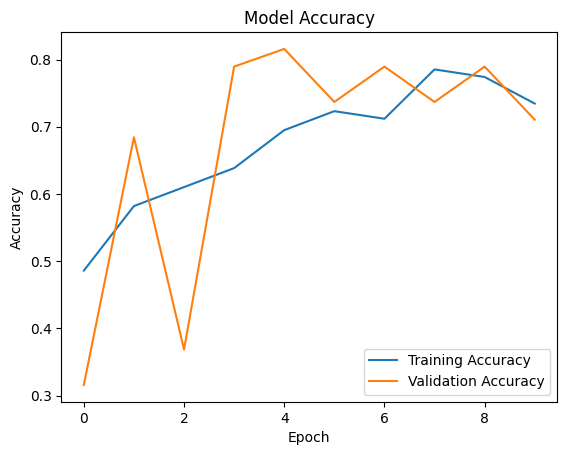

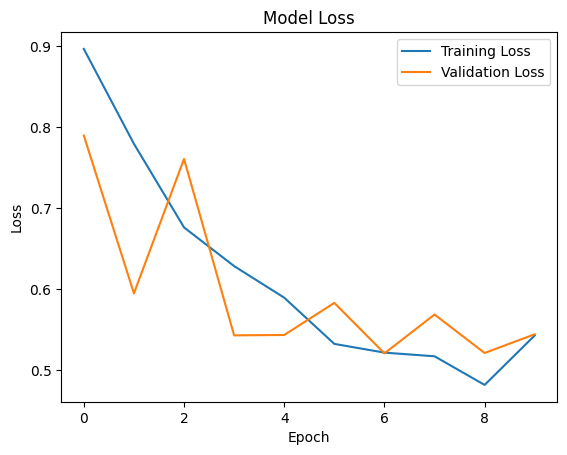

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# 10. Save Model

In [ ]:
model.save('brain_tumor_model.h5')  # Saves the model

# 11. Make Prediction

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('brain_tumor_detection_model.h5')

# Predict on a single image
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = np.stack((img,)*3, axis=-1)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    return "Tumor" if prediction > 0.5 else "No Tumor"

# Example
print(predict_image('/content/test.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
Tumor
